# LSTM for Sarcasm Detection

### Imports

In [10]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
import keras
import tensorflow as tf
from keras.layers import LSTM
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.1.0'

### Load data

In [3]:
df1 = pd.read_json("./data/Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("./data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
# re-order attibute columns in df2
df2 = df2[['article_link','headline','is_sarcastic']]
df = pd.concat([df1, df2], axis=0)
df = df.drop(['article_link'], axis=1)
print(len(df))
df.head()


55328


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
max_features = 10000
maxlen = 25
embedding_size = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['headline']))
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = df['is_sarcastic']

In [5]:
EMBEDDING_FILE = './embeddings/glove.6B.200d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8") if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\Users\elsas\Anaconda3\envs\TFM\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 5
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

C:\Users\elsas\Anaconda3\envs\TFM\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 85s 2ms/step - loss: 0.4724 - accuracy: 0.7561 - val_loss: 0.2461 - val_accuracy: 0.8968
Epoch 2/5
44262/44262 [==============================] - 87s 2ms/step - loss: 0.2313 - accuracy: 0.9192 - val_loss: 0.1722 - val_accuracy: 0.9325
Epoch 3/5
44262/44262 [==============================] - 87s 2ms/step - loss: 0.1364 - accuracy: 0.9558 - val_loss: 0.1148 - val_accuracy: 0.9584
Epoch 4/5
44262/44262 [==============================] - 85s 2ms/step - loss: 0.0816 - accuracy: 0.9737 - val_loss: 0.1158 - val_accuracy: 0.9655
Epoch 5/5
44262/44262 [==============================] - 84s 2ms/step - loss: 0.0514 - accuracy: 0.9843 - val_loss: 0.0794 - val_accuracy: 0.9798


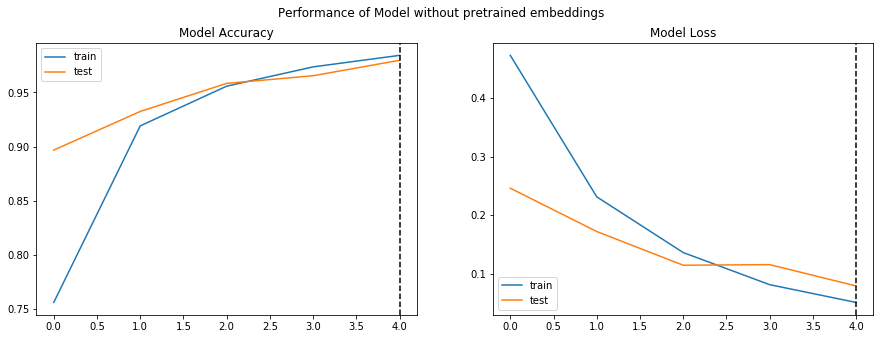

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model without pretrained embeddings")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

In [19]:
history.history['val_accuracy']

[0.8968009948730469,
 0.9324959516525269,
 0.9584312438964844,
 0.965479850769043,
 0.9797578454017639]

In [18]:
history.history['accuracy']

[0.7561113, 0.91916317, 0.95583117, 0.97365683, 0.98429805]

### Generate embeddings

https://nlp.stanford.edu/projects/glove/

### Split data into train, validation and test

We'll give 50% of the data to train and 25% each to validation and test.